In [41]:
import importlib
from makemore.prepare_data import generate_training_data
import makemore.neural_network
importlib.reload(makemore.neural_network)
from makemore.neural_network import NeuralNetwork, TrainingParams, InitializationType
import random 
from makemore.prepare_data import generate_character_mapping
import matplotlib.pyplot as plt
import numpy as np
import torch
import math


In [42]:

with open('data/names.txt', encoding='utf-8') as f:
    names = f.readlines()
    names = [name.strip() for name in names]

character_map = generate_character_mapping(names)
character_map

CharacterMapping(stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}, itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}, vocab_size=27)

In [43]:
random.seed(42)
random.shuffle(names)

n1 = int(len(names)*0.8)
n2 = int(len(names)*0.9)

X_train,Y_train  = generate_training_data(names[:n1],4)
X_val,Y_val = generate_training_data(names[n1:n2],4)
X_test,Y_test = generate_training_data(names[n2:],4)

nn_bad_initialization = NeuralNetwork(context_size=4,hidden_layer_neurons=150,letter_embedding_dimensions=3, print_flag=True, initialization_type=InitializationType.no_fixes)
nn_bad_initialization.train(X_train,Y_train, training_params= TrainingParams(iterations=1000, batch_size=50, learning_rate=lambda _: 0.1))


Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([12, 150])
Shape of b1: torch.Size([150])
Shape of w2: torch.Size([150, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 6108
Start training
Loss after 1 epochs: 24.230430603027344
Loss after 334 epochs: 3.1884913444519043
Loss after 667 epochs: 2.859893321990967
Loss after 1000 epochs: 2.858485698699951
NN_4_150_3 loss:after 1000 epochs: 2.846113920211792


# Playing with the initial loss

[Chapter in Youtube](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4&t=259s)

What to do we expect the loss to be at initialization? 

- Our loss function right now is the negative log likelihood average function.  If the probability is close to 0, the loss is exponentially high. 

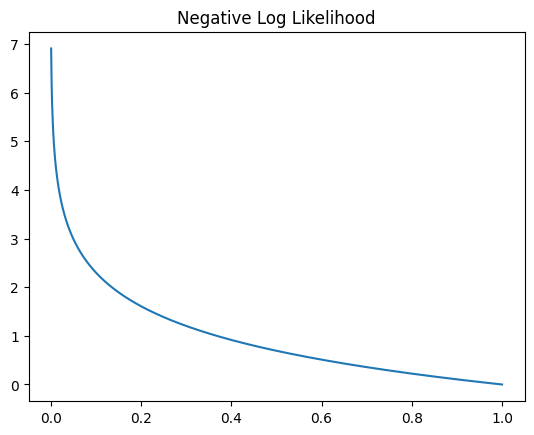

In [44]:
# visualize negativ log likelyhood with matplotlib

sample_xs = np.linspace(0.001, 1, 1000)
sample_ys = [-np.log(x) for x in sample_xs]
plt.plot(sample_xs,sample_ys)
plt.title("Negative Log Likelihood")
plt.show()


- Considering that we have 27 characters to be predicted, the average loss is a bit too high. 
- With uniform prediction we would have **(4 %/0.04)** chance of making the right guess. 
- From negative log likelihood perspectice, this should be average value around 3 visually looking

An example of this

In [45]:
-np.log(1/27)

3.295836866004329

Reallity hits us

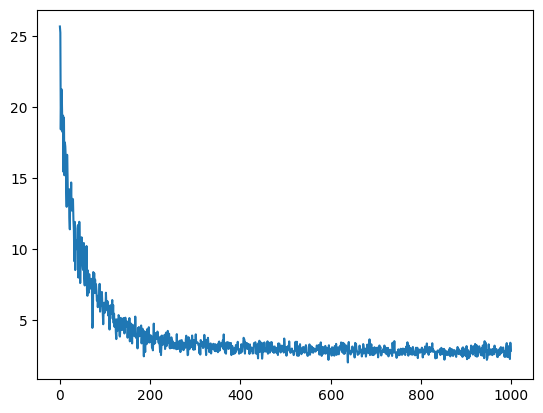

In [46]:
plt.plot(nn_bad_initialization.losses)

So why is it around 25-27 in the beginning of training in this case?

- We are randomly initializing the params. The logits generated are then run through sigmoid function which in itself actually powers the differences between predictions. If we are wrong, we are wrong powerfully and that is powered by out cost function: negative log likelihood function (visualized above)

So, how would you solve this?

- Perhaps initialize all parameters uniformly. So every possibility is equal. 


In [47]:

nn = NeuralNetwork(context_size=4,hidden_layer_neurons=150,letter_embedding_dimensions=3, print_flag=True,initialization_type=InitializationType.avoid_being_confidently_wrong)
nn.train(X_train,Y_train, training_params= TrainingParams(iterations=1000, batch_size=50, learning_rate=lambda _: 0.1))
for i in range(1):
    print(nn.generate_name())

Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([12, 150])
Shape of b1: torch.Size([150])
Shape of w2: torch.Size([150, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 6108
Start training
Loss after 1 epochs: 3.311779022216797
Loss after 334 epochs: 2.58786940574646
Loss after 667 epochs: 2.4951412677764893
Loss after 1000 epochs: 2.473161458969116
NN_4_150_3 loss:after 1000 epochs: 2.5582010746002197
[1, 4, 1, 20, 0]


Muchos bette

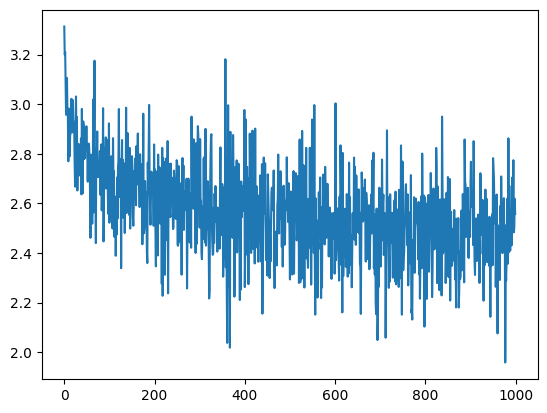

In [48]:
plt.plot(nn.losses)

# Tanh function result

First, lets look at tanh function

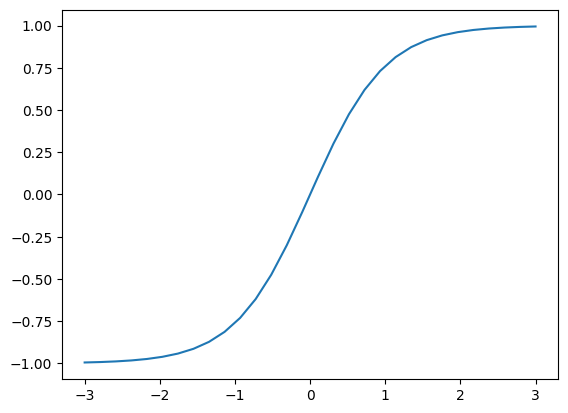

In [49]:
tan_graph = torch.linspace(-3,3,30).tanh()
plt.plot(torch.linspace(-3,3,30),tan_graph)

As we can see the tanh function squashes outputs to -1..1 interval. This means if input size is bigger than some theshold, then output is very close to -1/1. We can see it in the nn initialization as well.

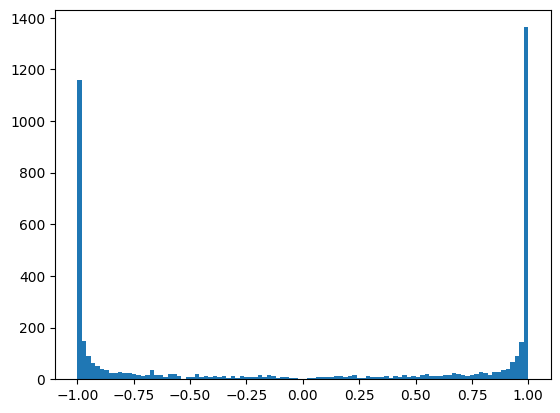

In [50]:

minibatch = torch.randint(0, len(X_train), (30,))
h = (nn.c[X_train[minibatch]].view(-1, nn.context_size * nn.letter_embedding_dimensions) @ nn.w1 + nn.b1).tanh()
histogram_plot = plt.hist(h.view(-1).tolist(), bins=100)


If we look at the input to the tanh function, the large set of outputs as -1/1 really makes sense. 

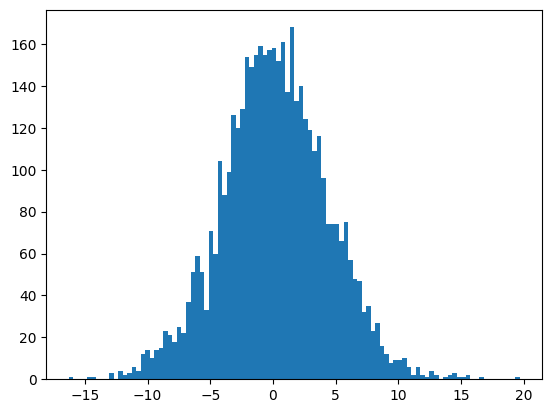

In [51]:
minibatch = torch.randint(0, len(X_train), (30,))
pre_h = nn.c[X_train[minibatch]].view(-1, nn.context_size * nn.letter_embedding_dimensions) @ nn.w1 + nn.b1
histogram_plot = plt.hist(pre_h.view(-1).tolist(), bins=100) 

According to Andrej Karpahty this is not good, why?

- If we look at tanh function and its gradient from the previous micrograd lecture, when the outcome of tanh function is 1 or -1 then the tanh gradient will become 0 and will make all the upstream parameters gradients also 0. If it happens to all data, then we have something called the dead gradient problem in our hands which means tha gradient is never updated with any data. 


~~~python
def tanh(self): # https://wikimedia.org/api/rest_v1/media/math/render/svg/b8dc4c309a551cafc2ce5c883c924ecd87664b0f
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
        self.grad += (1 - out.data**2) * out.grad
        self._gradient_updates+=1

    out._backward = _backward     
    return out
~~~

Showing locations where the tanh output equals 1 which means the gradient would equal to 0.  The white part in this graph is where h (outcome of tanh) is greater than 0.99

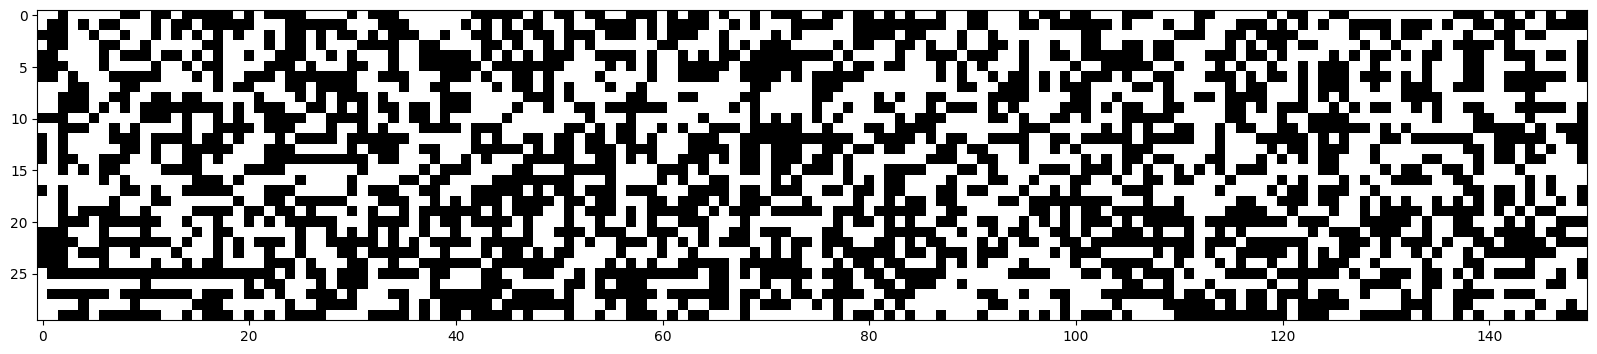

In [52]:
plt.figure(figsize=(20,10))
p=plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

Let's now look into the possibility of making the input to tanh squashed down

Shape of c: torch.Size([27, 3])
Shape of w1: torch.Size([12, 150])
Shape of b1: torch.Size([150])
Shape of w2: torch.Size([150, 27])
Shape of b2: torch.Size([27])
Total parameters currently in NN 6108


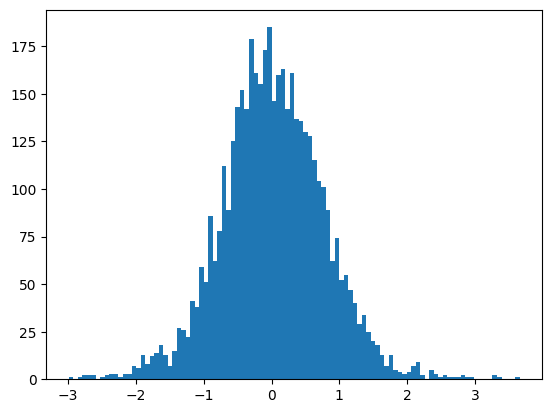

In [53]:
nn = NeuralNetwork(context_size=4,hidden_layer_neurons=150,letter_embedding_dimensions=3,print_flag=True,initialization_type=InitializationType.squash_h)
pre_h = nn.c[X_train[minibatch]].view(-1, nn.context_size * nn.letter_embedding_dimensions) @ nn.w1 + nn.b1

histogram_plot = plt.hist(pre_h.view(-1).tolist(), bins=100) 

Lets look at the tanh outcome histogram. Now the outcome is seldom 1 which means we don't also have the dead gradient problem in our hands. 

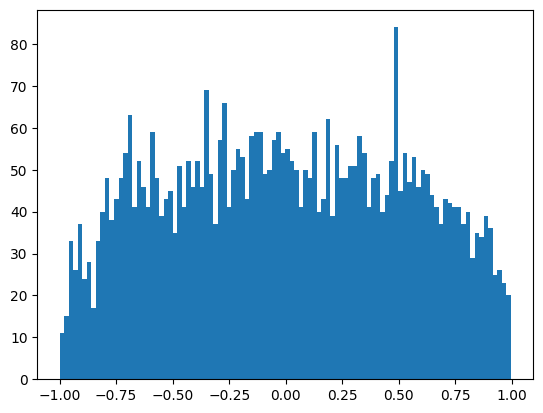

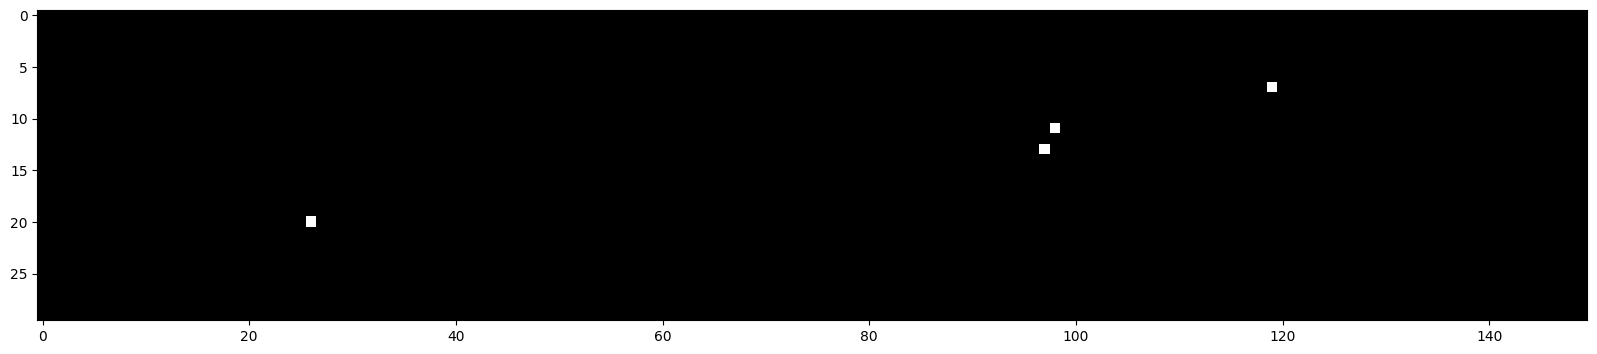

In [54]:

minibatch = torch.randint(0, len(X_train), (30,))
h = (nn.c[X_train[minibatch]].view(-1, nn.context_size * nn.letter_embedding_dimensions) @ nn.w1 + nn.b1).tanh()
histogram_plot = plt.hist(h.view(-1).tolist(), bins=100)

plt.figure(figsize=(20,10))
p=plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

As the above picture now is mostly black, we don't have tanh outcomes with result 1

# COMPARISON OF 3 METHODS

Loss for no initiialization fixes: 2.515362501144409
Loss for avoid being confidently wrong: 2.2835278511047363
Loss for squash h: 2.2617058753967285


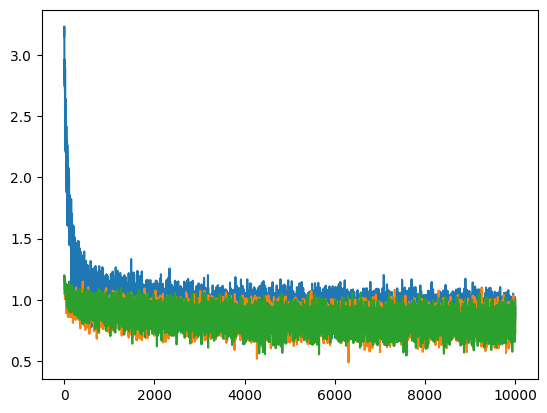

In [55]:
## Slow -- takes a minute or two to run

assigned_context_size = 4
letter_embedding_dimensions = 3
hidden_layer_neurons = 150


neural_networks = {
    "no initiialization fixes": NeuralNetwork(context_size=assigned_context_size,hidden_layer_neurons=hidden_layer_neurons,letter_embedding_dimensions=letter_embedding_dimensions, print_flag=False, initialization_type=InitializationType.no_fixes),
    "avoid being confidently wrong": NeuralNetwork(context_size=assigned_context_size,hidden_layer_neurons=hidden_layer_neurons,letter_embedding_dimensions=letter_embedding_dimensions, print_flag=False, initialization_type=InitializationType.avoid_being_confidently_wrong),
    "squash h": NeuralNetwork(context_size=assigned_context_size,hidden_layer_neurons=hidden_layer_neurons,letter_embedding_dimensions=letter_embedding_dimensions, print_flag=False, initialization_type=InitializationType.squash_h)
}    

for name, nn in neural_networks.items():
    nn.train(
        X_train,
        Y_train, 
        training_params= TrainingParams(iterations=10000, batch_size=50, learning_rate=lambda _: 0.1)
    )
    loss = nn.calculate_loss(X_val,Y_val)

    print(f"Loss for {name}: {loss}")

    plt.plot(np.log(nn.losses), label=name, scaley=True)